In [127]:
import torch
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from pathlib import Path
import pandas as pd
import math

from torchmetrics import MeanAbsolutePercentageError
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

In [2]:
ltv_frame = pd.read_csv("data.csv")
ltv_frame = ltv_frame.dropna().drop_duplicates()
ltv_frame.to_csv("clean_data.csv")
ltv_frame.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_135,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_141,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,COUNTRY_203,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0


In [ ]:
ltv_frame = pd.read_csv("encoded_data.csv")

In [3]:
ltv_frame.columns

Index(['total_sessions_day0', 'total_sessions_day1', 'total_sessions_day3',
       'total_sessions_day7', 'chapters_finished_day0',
       'chapters_finished_day1', 'chapters_finished_day3',
       'chapters_finished_day7', 'chapters_opened_day0',
       'chapters_opened_day1', 'chapters_opened_day3', 'chapters_opened_day7',
       'chapters_closed_day0', 'chapters_closed_day1', 'chapters_closed_day3',
       'chapters_closed_day7', 'diamonds_received_day0',
       'diamonds_received_day1', 'diamonds_received_day3',
       'diamonds_received_day7', 'diamonds_spent_day0', 'diamonds_spent_day1',
       'diamonds_spent_day3', 'diamonds_spent_day7', 'tickets_spent_day0',
       'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7',
       'retained_day1', 'retained_day3', 'retained_day7',
       'chapters_finished_session1', 'chapters_finished_session3',
       'chapters_finished_session9', 'chapters_opened_session1',
       'chapters_opened_session3', 'chapters_opened_session9'

In [26]:
income_per_country = ltv_frame[['country_code', 'target_full_ltv_day30']].groupby('country_code').agg(
    average_ltv = pd.NamedAgg(column='target_full_ltv_day30', aggfunc=np.mean)
)['average_ltv']
income_per_country = income_per_country.sort_values(ascending=False)

income_per_source = ltv_frame[['media_source', 'target_full_ltv_day30']].groupby('media_source').agg(
    average_ltv = pd.NamedAgg(column='target_full_ltv_day30', aggfunc=np.mean)
)['average_ltv']
income_per_source = income_per_source.sort_values(ascending=False)

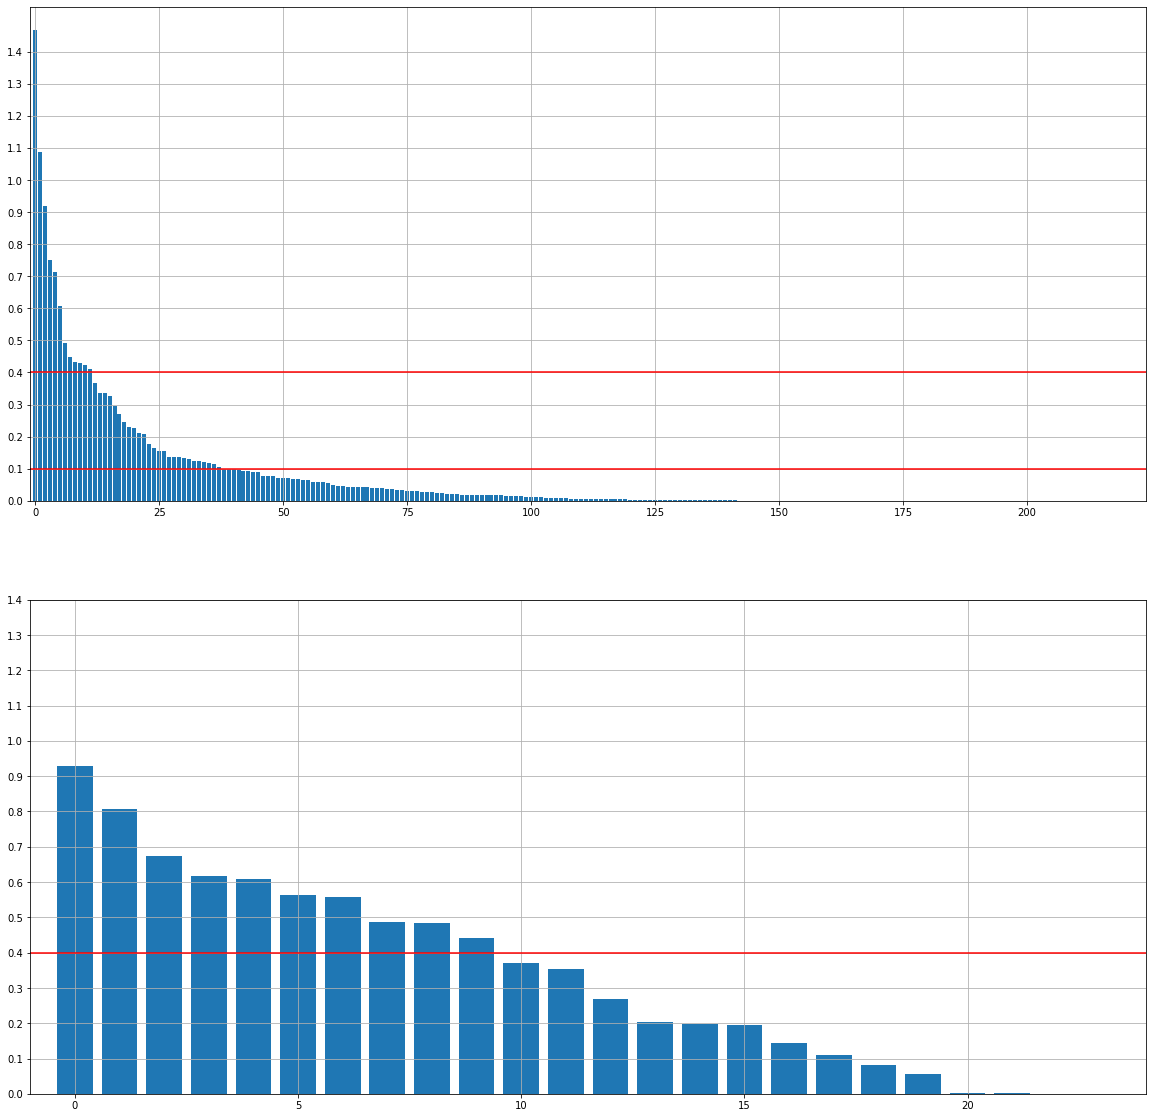

In [ ]:
country_categories = [0.1, 0.4]
country_count = len(income_per_country)
source_categories = [0.4]
source_count = len(income_per_source)

fig, ax = plt.subplots(nrows = 2, figsize=(20, 20))

ax[0].bar(range(country_count), income_per_country.values)
for category in country_categories:
    ax[0].plot([-1, country_count], [category, category], color="r")
ax[0].set_xlim(-1, country_count)
ax[0].yaxis.set_ticks(np.arange(0, 1.5, 0.1))
ax[0].grid()

ax[1].bar(range(len(income_per_source)), income_per_source.values)
for category in source_categories:
    ax[1].plot([-1, source_count], [category, category], color="r")
ax[1].set_xlim(-1, source_count)
ax[1].yaxis.set_ticks(np.arange(0, 1.5, 0.1))
ax[1].grid()

In [67]:
category_dict = {}
for id, value in income_per_country.items():
    category = 0
    for threshold in country_categories:
        if value >= threshold: category += 1
        else: break
    category_dict[id] = category

for id, value in income_per_source.items():
    category = 0
    for threshold in source_categories:
        if value >= threshold: category += 1
        else: break
    category_dict[id] = category

category_dict['android'] = 0
category_dict['ios'] = 1
print(category_dict)

{'COUNTRY_96': 2, 'COUNTRY_143': 2, 'COUNTRY_168': 2, 'COUNTRY_55': 2, 'COUNTRY_65': 2, 'COUNTRY_141': 2, 'COUNTRY_188': 2, 'COUNTRY_38': 2, 'COUNTRY_72': 2, 'COUNTRY_155': 2, 'COUNTRY_204': 2, 'COUNTRY_160': 2, 'COUNTRY_26': 1, 'COUNTRY_1': 1, 'COUNTRY_129': 1, 'COUNTRY_194': 1, 'COUNTRY_15': 1, 'COUNTRY_181': 1, 'COUNTRY_5': 1, 'COUNTRY_138': 1, 'COUNTRY_210': 1, 'COUNTRY_185': 1, 'COUNTRY_23': 1, 'COUNTRY_213': 1, 'COUNTRY_8': 1, 'COUNTRY_156': 1, 'COUNTRY_147': 1, 'COUNTRY_85': 1, 'COUNTRY_163': 1, 'COUNTRY_133': 1, 'COUNTRY_146': 1, 'COUNTRY_201': 1, 'COUNTRY_176': 1, 'COUNTRY_161': 1, 'COUNTRY_43': 1, 'COUNTRY_27': 1, 'COUNTRY_150': 1, 'COUNTRY_89': 1, 'COUNTRY_103': 1, 'COUNTRY_102': 1, 'COUNTRY_132': 0, 'COUNTRY_42': 0, 'COUNTRY_203': 0, 'COUNTRY_197': 0, 'COUNTRY_114': 0, 'COUNTRY_202': 0, 'COUNTRY_148': 0, 'COUNTRY_52': 0, 'COUNTRY_91': 0, 'COUNTRY_49': 0, 'COUNTRY_7': 0, 'COUNTRY_53': 0, 'COUNTRY_187': 0, 'COUNTRY_81': 0, 'COUNTRY_60': 0, 'COUNTRY_104': 0, 'COUNTRY_107': 0, 

In [131]:
columns_float = ['chapters_finished_day0',
'chapters_finished_day1', 'chapters_finished_day3',
'chapters_finished_day7', 'chapters_opened_day0',
'chapters_opened_day1', 'chapters_opened_day3', 'chapters_opened_day7',
'chapters_closed_day0', 'chapters_closed_day1', 'chapters_closed_day3',
'chapters_closed_day7', 'diamonds_received_day0',
'diamonds_received_day1', 'diamonds_received_day3',
'diamonds_received_day7', 'diamonds_spent_day0', 'diamonds_spent_day1',
'diamonds_spent_day3', 'diamonds_spent_day7', 'tickets_spent_day0',
'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7',
'app_sub_ltv_day0', 'app_sub_ltv_day1',
'app_sub_ltv_day3', 'app_iap_ltv_day0', 'app_iap_ltv_day1',
'app_iap_ltv_day3', 'ad_ltv_day0', 'ad_ltv_day1', 'ad_ltv_day3']

columns_categorical = ['media_source', 'country_code', 'platform']

columns_target = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30']

In [192]:
class LTV_data(Dataset):
    def __init__(self, df, category_dict):
        self.df = df
        self.dict = category_dict
    
    def __getitem__(self, index):
        feature_1 = self.df.iloc[index][columns_float].values.astype(np.float64)
        feature_2 = self.df.iloc[index][columns_categorical].values
        #print(type(feature_2))
        if type(feature_2[0]) == str:
            feature_2 = np.array([self.dict[key] for key in feature_2])
        feature_2 = feature_2.astype(np.float64)
        feature = np.concatenate([feature_1, feature_2])
        target = self.df.iloc[index][columns_target].values.astype(np.float64)
        return feature, target

    def __len__(self) -> int:
        return len(self.df)

    @staticmethod
    def create_dataset(df, category_dict, transform=None):
       dataset = LTV_data(df, category_dict)
       return dataset

    @staticmethod
    def loader(dataset, batch_size, num_workers=0):
       data_loader = DataLoader(
          dataset,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
      )
       return data_loader

In [193]:
val_set_size, test_set_size = 20000, 20000

all_data = LTV_data.create_dataset(ltv_frame, category_dict)
train_set, val_set, test_set = torch.utils.data.random_split(all_data, [all_data.__len__() - (val_set_size + test_set_size), val_set_size, test_set_size])
train_loader = LTV_data.loader(train_set, 64)
val_loader = LTV_data.loader(val_set, 64)
test_loader = LTV_data.loader(test_set, 64)

In [187]:
ltv_frame.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [194]:
features, targets = next(iter(train_loader))

In [181]:
EPOCHS = 2
input_size = features.shape[1]
learning_rate = 0.001

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

In [182]:
class LTV_model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Sequential(nn.Linear(input_size, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU())
        self.f2 = nn.Linear(32, 3)
        self.f3 = nn.Threshold(0.1, 0)

    def forward(self, X):
        X = self.f1(X)
        X = F.dropout(X, p = 0.25)
        X = self.f2(X)
        X = self.f3(X)
        return X

In [183]:
model = LTV_model()
#checkpoint = torch.load('./model.pt')
#model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [184]:
checkpoint = torch.load('./model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [200]:
def train(model, loader, opt, criterion):
    denominator = 100
    print('training to', len(loader) // denominator, end=':')

    rmse = 0
    mape = 0
    mae = 0

    model.train()
    
    i = 1
    for (features, targets) in loader:
        if i % denominator == 0:
            print(i // denominator, end=';')
            if i % (denominator * 100) == 0:
                print('')
        i += 1

        opt.zero_grad()
        
        features = features.float()
        targets = targets.float()

        output = model(features)
        #print(output)
        loss = criterion(output, targets)
        
        loss.backward()

        #rmse += math.sqrt(MeanSquaredError()(output, targets).item())
        mape += MeanAbsolutePercentageError()(output, targets).item()
        #mae += MeanAbsoluteError()(output, targets).item()

        opt.step()
        #print(mse, end=';')
        #if i == 2:
        #    break

    rmse = math.sqrt(rmse) / len(loader)
    mape = mape / len(loader)
    mae = mae / len(loader)
    return rmse, mape, mae

In [201]:
def evaluate(model, loader, criterion):
    denominator = 100
    print('validation to', len(loader) // denominator, end=':')

    rmse = 0
    mape = 0
    mae = 0

    model.eval()
    
    i = 1
    with torch.no_grad():
        for (features, targets) in loader:
            if i % denominator == 0:
                print(i // denominator, end=';')
            if i % (denominator * 100) == 0:
                print('')
            i += 1
            
            features = features.float()
            targets = targets.float()

            output = model(features)

            rmse += math.sqrt(MeanSquaredError()(output, targets).item())
            mape += MeanAbsolutePercentageError()(output, targets).item()
            mae += MeanAbsoluteError()(output, targets).item()
        
    rmse = math.sqrt(rmse) / len(loader)
    mape = mape / len(loader)
    mae = mae / len(loader)
    return rmse, mape, mae

In [185]:
train_rmse_list = []
train_mape_list = []
train_mae_list = []
val_rmse_list = []
val_mae_list = []
val_mape_list = []
test_rmse_list = []
test_mape_list = []
test_mae_list = []

In [202]:
for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_rmse, train_mape, train_mae = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_rmse,
            }, './model.pt')
    
    val_start_time = time.monotonic()
    val_rmse, val_mape, val_mae = evaluate(model, val_loader, criterion)
    val_end_time = time.monotonic()
    
    test_start_time = time.monotonic()
    test_rmse, test_mape, test_mae = evaluate(model, test_loader, criterion)
    test_end_time = time.monotonic()
    
    train_rmse_list.append(train_rmse)
    train_mape_list.append(train_mape)
    train_mae_list.append(train_mae)
    val_rmse_list.append(val_rmse)
    val_mape_list.append(val_mape)
    val_mae_list.append(val_mae)
    test_rmse_list.append(test_rmse)
    test_mape_list.append(test_mape)
    test_mae_list.append(test_mae)
    
    print("Training: RMSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (train_rmse, train_mape, train_mae, train_end_time - train_start_time))
    print("Validation: MSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (val_rmse, val_mape, val_mae, val_end_time - val_start_time))
    print("Test: MSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (test_rmse, test_mape, test_mae, val_end_time - val_start_time))
    print("")

Epoch-0: 
training to 91:1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;validation to 3:1;2;3;validation to 3:1;2;3;Training: RMSE = 0.0000, MAPE = 48712.5956, MAE = 0.0000, Time = 2331.44 seconds
Validation: MSE = 0.0504, MAPE = 46373.6661, MAE = 0.1673, Time = 77.50 seconds
Test: MSE = 0.0477, MAPE = 46257.3003, MAE = 0.1595, Time = 77.50 seconds

Epoch-1: 
training to 91:1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;32;33;34;35;36;37;38;39;40;41;42;43;44;45;46;47;48;49;50;51;52;53;54;55;56;57;58;59;60;61;62;63;64;65;66;67;68;69;70;71;72;73;74;75;76;77;78;79;80;81;82;83;84;85;86;87;88;89;90;91;validation to 3:1;2;3;validation to 3:1;2;3;Training: RMSE = 0.0000, MAPE = 51439.0631, MAE = 0.0000, Time = 2245.84 seconds
Validation: MSE =

In [154]:
print("Training: RMSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (train_rmse, train_mape, train_mae, train_end_time - train_start_time))

Training: RMSE = 0.0100, MAPE = 67941.0919, MAE = 0.2114, Time = 2133.92 seconds


In [197]:
print("Training: RMSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (train_rmse, train_mape, train_mae, train_end_time - train_start_time))

Training: RMSE = 0.0092, MAPE = 49892.2874, MAE = 0.1716, Time = 2441.30 seconds


In [203]:
print("Training: RMSE = %.4f, MAPE = %.4f, MAE = %.4f, Time = %.2f seconds" % (train_rmse, train_mape, train_mae, train_end_time - train_start_time))

Training: RMSE = 0.0000, MAPE = 51439.0631, MAE = 0.0000, Time = 2245.84 seconds


In [155]:
for id, value in category_dict.items():
    ltv_frame = ltv_frame.replace([id], value)

In [159]:
ltv_frame.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,...,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,2,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,...,2021-12-03,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [160]:
ltv_frame.to_csv('encoded_data.csv')

In [153]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_rmse,
            }, './model.pt')

In [ ]:
checkpoint = torch.load('./model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(model.state_dict())

In [18]:
money = ltv_frame[['target_full_ltv_day30']]
count = 0
i = 0
for row in money.iterrows():
    if row[1].iloc[0] != 0.0:
        count += 1
print(count)
print(count / len(money))

343293
0.23387758272063833
